#### Se añade la opción de guardar la subred corrupta creada (reparar títulos de las gráficas)


==================== PAÍS: MÉXICO ====================

========== PORCENTAJE MASA CRÍTICA = 50% ==========

========== ESTRATEGIAS CM = SoloK (K) ==========

===== HOMOFILIA = 0.0 =====

===== RED: Barabási-Albert {'m': 1} =====

===== CM Placement: Nodos centrales =====

--- Sim: México / Barabási-Albert{'m': 1} / CM:Cen(50% K) / H=0.0 ---
Creando red tipo 'Barabási-Albert'...
Red creada: 100 nodos, 99 enlaces.
Calculando centralidad...
  Usando centralidad de Eigenvector.
Seleccionando 50 nodos CM (Nodos centrales)...
Inicializando estrategias: CM=['K'], No-CM=['C', 'D', 'H'] con seed=42...
  Estrategias iniciales: Counter({'K': 50, 'D': 17, 'C': 17, 'H': 16})
Iniciando 50 rondas (H=0.0, CM=Nodos centrales, Strats CM=['K'])...
  Ronda 50/50 completada.
Simulación completada.
Gráfica de evolución guardada como 'Resultados_N100_I50\México\CM_P50\CM_SSoloK\Red_Barabási-Albert_m1\Cen_h00\evolucion_méxico_Barabási-Albert_(m=1)_CM50CenK_h00.svg'
  Calculando layout para red Barabási-Albe

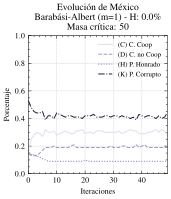


--- México/BA/m1/Cen/SoloK/50%CM/H0.0 Red ---


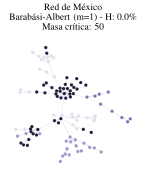


--- México/BA/m1/Cen/SoloK/50%CM/H0.0 SubK Data ---
  Datos de red guardados en: Resultados_N100_I50\México\CM_P50\CM_SSoloK\Red_Barabási-Albert_m1\Cen_h00\subgrafo_k_méxico_Barabási-Albert_(m=1)_CM50CenK_h00.graphml

--- México/BA/m1/Cen/SoloK/50%CM/H0.0 SubK Img ---


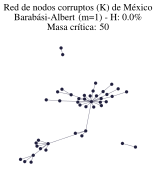

In [ ]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scienceplots
import os
from collections import Counter
import time
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display, Image
except ImportError:
    SVG, display, Image = None, None, None

# --- Parámetros Juego y Funciones Auxiliares (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    # ... (igual) ...
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    # ... (igual) ...
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual

def calcular_centralidad(red):
    # ... (igual) ...
    try: centrality = nx.eigenvector_centrality_numpy(red); print("  Usando centralidad de Eigenvector.")
    except Exception as e: print(f"  Advertencia: Eigenvector falló ({e}). Usando Grado."); centrality = nx.degree_centrality(red)
    return centrality

def seleccionar_nodos_cm(centrality_dict, cm_size, placement_type):
    # ... (igual) ...
    cm_size = int(round(cm_size))
    if not 0 < cm_size <= len(centrality_dict):
        if cm_size == 0 or cm_size == len(centrality_dict): print(f"  Advertencia: CM size es {cm_size}, todos o ninguno serán CM.")
        else: raise ValueError(f"CM size ({cm_size}) inválido para {len(centrality_dict)} nodos.")
    reverse_sort = (placement_type == 'Nodos centrales')
    nodos_ordenados = sorted(centrality_dict, key=centrality_dict.get, reverse=reverse_sort)
    if placement_type in ['Nodos centrales', 'Nodos perifericos']: cm_nodes = nodos_ordenados[:cm_size]
    elif placement_type == 'Nodos aleatorios':
        if cm_size == 0: cm_nodes = []
        elif cm_size == len(centrality_dict): cm_nodes = list(centrality_dict.keys())
        else: cm_nodes = random.sample(list(centrality_dict.keys()), cm_size)
    else: raise ValueError(f"Colocación CM desconocida: {placement_type}")
    return cm_nodes

def inicializar_estrategias_cm_flexible(n, cm_nodes, cm_strategies, non_cm_strategies, seed=None):
    # ... (igual) ...
    if seed is not None: random.seed(seed)
    estrategias = {}; non_cm_nodes = list(set(range(n)) - set(cm_nodes))
    if not cm_strategies and cm_nodes : raise ValueError("cm_strategies vacía pero cm_nodes no lo está.")
    if not non_cm_strategies and non_cm_nodes: raise ValueError("non_cm_strategies vacía pero non_cm_nodes no lo está.")
    random.shuffle(cm_nodes); random.shuffle(non_cm_nodes)
    if cm_strategies:
        for i, nodo in enumerate(cm_nodes): estrategias[nodo] = cm_strategies[i % len(cm_strategies)]
    if non_cm_strategies:
        for i, nodo in enumerate(non_cm_nodes): estrategias[nodo] = non_cm_strategies[i % len(non_cm_strategies)]
    return dict(sorted(estrategias.items()))

def ejecutar_simulacion_corrupcion(
    num_nodos=100, network_type='Completa', network_params=None,
    cm_size_actual=50, cm_placement_type='Nodos aleatorios',
    cm_strategies = ['C', 'H'], non_cm_strategies = ['D', 'K'],
    params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0,
    rondas=15, seed=None, cm_porcentaje=50 # <--- Añadido para el título cm_title_str
    ):
    # ... (igual que antes, solo se usa cm_porcentaje para el título) ...
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}'...")
    network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada: {red.number_of_nodes()} nodos, {red.number_of_edges()} enlaces.")
    print(f"Calculando centralidad...")
    centrality = calcular_centralidad(red)
    print(f"Seleccionando {cm_size_actual} nodos CM ({cm_placement_type})...")
    cm_nodes = seleccionar_nodos_cm(centrality, cm_size_actual, cm_placement_type)
    print(f"Inicializando estrategias: CM={cm_strategies}, No-CM={non_cm_strategies} con seed={seed}...")
    estrategias = inicializar_estrategias_cm_flexible(num_nodos, cm_nodes, cm_strategies, non_cm_strategies, seed=seed)
    counts_init = Counter(estrategias.values()); print(f"  Estrategias iniciales: {counts_init}")
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    print(f"Iniciando {rondas} rondas (H={homophily_strength}, CM={cm_placement_type}, Strats CM={cm_strategies})...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        conteo_actual = Counter(estrategias.values())
        for strat_key in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat_key].append(fraccion)
        if (r + 1) % 50 == 0: print(f"  Ronda {r+1}/{rondas} completada.")
    print("Simulación completada.")
    cm_strat_str_file = "".join(sorted(cm_strategies))
    if cm_placement_type == 'Nodos centrales': cm_placement_label_file = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label_file = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label_file = "Ale"
    else: cm_placement_label_file = cm_placement_type[:3].lower()
    cm_info_str = f"_CM{int(round(cm_size_actual))}{cm_placement_label_file}{cm_strat_str_file}"
    cm_title_str = f"Masa crítica: {cm_porcentaje}\\% - {cm_placement_type} ({','.join(cm_strategies)})" # Usar cm_porcentaje
    return historia_fracciones, red, estrategias, network_type, network_params_str_out, cm_info_str, cm_title_str

# --- Funciones de Graficado (sin cambios, solo se ajusta cm_title_str) ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, cm_title_str, filename):
    # ... (igual) ...
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': '(C) C. Coop', 'D': '(D) C. no Coop', 'H': '(H) P. Honrado', 'K': '(K) P. Corrupto'}
    rondas_totales = len(historia_fracciones['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1)
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); plt.title(f"Evolución de {titulo}\n{network_type_str} - H: {homophily_str}\\% \n{cm_title_str}")
    plt.ylim(0, 1.0); plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1); plt.legend(fontsize=7, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"Gráfica de evolución guardada como '{filename}'"); plt.close()

def graficar_red_final(red, estrategias_finales, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    # ... (igual) ...
    if not isinstance(red, nx.Graph) or not red.nodes(): return None
    plt.style.use(['science', 'ieee']); fig_size = (3.5, 3.5) if network_type == 'Completa' else (2.5, 2.5); plt.figure(figsize=fig_size); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]
    print(f"  Calculando layout para red {network_type} ({n} nodos)..."); start_time = time.time()
    try: pos = nx.spring_layout(red, seed=42, k=0.6/np.sqrt(n) if n>0 else 0.1, iterations=50 if network_type=='Barabási-Albert' else 30)
    except Exception: pos = nx.circular_layout(red)
    print(f"  Layout calculado en {time.time() - start_time:.2f} seg.")
    print(f"  Dibujando red final {network_type}..."); node_size = 10 if network_type == 'Completa' else 10; nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=node_size, linewidths=0.1, edgecolors='face')
    edge_alpha = 0.5 if network_type == 'Completa' else 0.5; edge_width = 0.5 if network_type == 'Completa' else 0.3; nx.draw_networkx_edges(red, pos, edge_color="#A7A7A7", alpha=edge_alpha, width=edge_width)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.title(f"Red de {titulo}\n{title_net_part} - H: {homophily_str}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); save_format = "png" if network_type == 'Completa' else "svg"; save_dpi = 150 if network_type == 'Completa' else 300; plt.savefig(filename, format=save_format, dpi=save_dpi, bbox_inches='tight'); print(f"  Gráfica de red final guardada como '{filename}' (Formato: {save_format})"); plt.close()
    return pos

def graficar_subgrafo_k(red_original, estrategias_finales, pos_original, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename_img):
    nodos_k = [nodo for nodo, strat in estrategias_finales.items() if strat == 'K']
    if not nodos_k: print(f"  No nodos 'K' p/ subgrafo en {titulo}."); return None, None # Devuelve None para el path del archivo de datos también
    print(f"  Creando subgrafo 'K' ({len(nodos_k)} nodos)..."); subgrafo_k = red_original.subgraph(nodos_k).copy() # .copy() para evitar modificar el original
    # No es necesario filtrar nodos_a_dibujar aquí si pos_original siempre contiene todos los nodos
    pos_k = {nodo: pos_original[nodo] for nodo in nodos_k if nodo in pos_original}
    if len(pos_k) != len(nodos_k):
        print("  Advertencia: No se encontraron posiciones para todos los nodos K en subgrafo. Se graficarán los que tengan posición.")
        # Si pos_k es vacío, no se puede graficar
        if not pos_k:
            print("  Subgrafo K vacío o sin posiciones, no se puede graficar ni guardar.")
            return None, None
        subgrafo_k = subgrafo_k.subgraph(pos_k.keys()).copy() # Asegurarse que subgrafo_k solo tenga nodos con posición
        if not subgrafo_k.nodes():
             print("  Subgrafo K resultante es vacío después de filtrar posiciones.")
             return None, None


    # Graficar la imagen
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    nx.draw_networkx_nodes(subgrafo_k, pos_k, nodelist=list(subgrafo_k.nodes()), node_color='#201F3D', node_size=10, linewidths=0.1, edgecolors='face')
    nx.draw_networkx_edges(subgrafo_k, pos_k, edge_color="#201F3D", alpha=0.6, width=0.4)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type
    plt.title(f"Red de nodos corruptos (K) de {titulo}\n{title_net_part} - H: {homophily_str}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename_img), exist_ok=True)
    plt.savefig(filename_img, format="svg", dpi=300, bbox_inches='tight')
    print(f"  Gráfica de subgrafo K guardada como '{filename_img}'")
    plt.close()

    # Guardar los datos de la subred K (GraphML)
    filename_data = filename_img.replace(".svg", ".graphml")
    try:
        nx.write_graphml(subgrafo_k, filename_data)
        print(f"  Datos de subgrafo K guardados como '{filename_data}'")
    except Exception as e:
        print(f"  Error al guardar subgrafo K como GraphML: {e}")
        filename_data = None # No se pudo guardar

    return filename_img, filename_data # Devuelve path de imagen y de datos

# --- Función Principal (Modificada para guardar subgrafo K) ---
def simular_y_graficar_pais(
    nombre_pais, params_juego, num_nodos,
    network_type, network_params,
    cm_porcentaje_actual, cm_placement_type,
    cm_strategies, non_cm_strategies,
    K, homophily_strength, rondas, seed,
    output_dir="Resultados_Corrupcion",
    graficar_redes=True, graficar_subgrafo_k_img_flag=True, guardar_subgrafo_k_datos_flag=True # Nuevo flag para datos
    ):
    cm_size_actual = int(round((cm_porcentaje_actual / 100) * num_nodos))
    cm_strats_str_label = "".join(sorted(cm_strategies))
    if cm_placement_type == 'Nodos centrales': cm_placement_label = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label = "Ale"
    else: cm_placement_label = cm_placement_type[:3].lower()
    print(f"\n--- Sim: {nombre_pais} / {network_type}{network_params} / CM:{cm_placement_label}({cm_porcentaje_actual}% {cm_strats_str_label}) / H={homophily_strength} ---")

    historia, red_final, estrategias_finales, net_type_used, net_params_str_out, cm_info_str, cm_title_str = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params,
        cm_size_actual=cm_size_actual, cm_placement_type=cm_placement_type,
        cm_strategies=cm_strategies, non_cm_strategies=non_cm_strategies,
        params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed, cm_porcentaje=cm_porcentaje_actual # Pasar porcentaje para título
    )
    homophily_file_str = f"_h{homophily_strength:.1f}".replace('.', '')
    homophily_title_str = f"{homophily_strength:.1f}"
    cm_title_str_for_graphs = f"Masa crítica: {cm_porcentaje_actual}% - {cm_placement_type} ({','.join(cm_strategies)})"
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str_out}{cm_info_str}{homophily_file_str}"
    network_title_str = f"{net_type_used}{net_params_str_out.replace('_', ' ')}"

    path_grafica_evolucion = os.path.join(output_dir, f"evolucion_{nombre_base}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, cm_title_str_for_graphs, path_grafica_evolucion)

    pos_calculado = None; path_grafica_red_final = None
    if graficar_redes:
        format_red = 'png' if net_type_used == 'Completa' else 'svg'
        path_grafica_red_final = os.path.join(output_dir, f"red_final_{nombre_base}.{format_red}")
        pos_calculado = graficar_red_final(red_final, estrategias_finales, nombre_pais, net_type_used, net_params_str_out, homophily_title_str, cm_title_str_for_graphs, path_grafica_red_final)

    path_grafica_subgrafo_k_img = None; path_datos_subgrafo_k = None
    # Solo intentar si hay posiciones y se solicita imagen o datos
    if (graficar_subgrafo_k_img_flag or guardar_subgrafo_k_datos_flag):
        if pos_calculado is None and graficar_redes: # Evitar recalcular si ya se hizo
            print("  Advertencia: No se graficó red final, recalculando posiciones para subgrafo K...")
            try: pos_calculado = nx.spring_layout(red_final, seed=seed, k=0.6/np.sqrt(num_nodos) if num_nodos>0 else 0.1, iterations=50 if net_type_used=='Barabási-Albert' else 30)
            except Exception: pos_calculado = None

        if pos_calculado:
            filename_base_subgrafo_k = os.path.join(output_dir, f"subgrafo_k_{nombre_base}")
            # La función graficar_subgrafo_k ahora se encarga de guardar imagen Y datos
            # si graficar_subgrafo_k_img_flag es True para la imagen
            # y siempre intenta guardar datos si guardar_subgrafo_k_datos_flag es True (dentro de la función)
            # Esto necesita una reestructuración o pasar ambos flags a la función
            # Por simplicidad, hagamos que graficar_subgrafo_k siempre intente guardar datos
            # y la imagen solo si graficar_subgrafo_k_img_flag es True.

            # Revisión: graficar_subgrafo_k ya intenta guardar datos si la imagen se crea
            # Vamos a mantenerlo así y solo llamar si se quiere la imagen O los datos.
            # Si solo se quieren datos, la imagen se creará igual (podría ser opcional).

            # Para simplificar, vamos a llamar a graficar_subgrafo_k que ahora también guarda datos
            if graficar_subgrafo_k_img_flag or guardar_subgrafo_k_datos_flag:
                 path_grafica_subgrafo_k_img, path_datos_subgrafo_k = graficar_subgrafo_k(
                     red_final, estrategias_finales, pos_calculado, nombre_pais,
                     net_type_used, net_params_str_out, homophily_title_str,
                     cm_title_str_for_graphs, filename_base_subgrafo_k + ".svg" # Pasar base para imagen
                 )
                 if not graficar_subgrafo_k_img_flag and path_grafica_subgrafo_k_img and os.path.exists(path_grafica_subgrafo_k_img):
                     os.remove(path_grafica_subgrafo_k_img) # Eliminar imagen si solo se querían datos
                     path_grafica_subgrafo_k_img = None
        else:
            print("  No pos, omitiendo subgrafo K (imagen y datos).")


    print(f"--- Simulación completada ---")
    return path_grafica_evolucion, path_grafica_red_final, path_grafica_subgrafo_k_img, path_datos_subgrafo_k


# --- Ejemplo de Uso (Modificado para guardar datos subgrafo K) ---
if __name__ == "__main__":
    NODOS = 1000
    RONDAS = 500
    SEED_GLOBAL = 42
    GRAFICAR_REDES_FINALES = True
    GRAFICAR_SUBGRAFO_K_IMG = True     # Flag para la imagen del subgrafo K
    GUARDAR_SUBGRAFO_K_DATOS = True  # Flag para guardar los datos del subgrafo K

    PAISES_A_SIMULAR = ['México', 'Dinamarca', 'Singapur']
    config_paises = { 'Dinamarca': PARAMS_DINAMARCA, 'Singapur': PARAMS_SINGAPUR, 'México': PARAMS_MEXICO }
    config_cm_porcentajes = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
    niveles_homofilia = [0.0,0.9,1.0]
    config_redes = [ {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}} ]
    config_cm_placement = ['Nodos aleatorios', 'Nodos centrales', 'Nodos perifericos']
    config_cm_strategies = [ {'label': 'SoloK', 'cm_strats': ['K'], 'non_cm_strats': ['C', 'D', 'H']} ]

    nombre_directorio_base = f'N{NODOS}_I{RONDAS}'
    OUTPUT_DIR_GLOBAL = nombre_directorio_base
    paths_graficas_y_datos = {} # Cambiado para incluir datos

    paises_filtrados = {pais: config_paises[pais] for pais in PAISES_A_SIMULAR if pais in config_paises}
    if not paises_filtrados: print(f"Advertencia: Países no encontrados: {PAISES_A_SIMULAR}")

    for pais, params_juego_pais in paises_filtrados.items():
        print(f"\n==================== PAÍS: {pais.upper()} ====================")
        for cm_porcentaje in config_cm_porcentajes:
            # CM_SIZE_ACTUAL = int(round((cm_porcentaje / 100) * NODOS))
            print(f"\n========== PORCENTAJE MASA CRÍTICA = {cm_porcentaje}% ==========")
            for cm_strat_config in config_cm_strategies:
                cm_label = cm_strat_config['label']
                cm_strats_list = cm_strat_config['cm_strats']
                non_cm_strats_list = cm_strat_config['non_cm_strats']
                print(f"\n========== ESTRATEGIAS CM = {cm_label} ({','.join(cm_strats_list)}) ==========")
                for homophily_level in niveles_homofilia:
                    print(f"\n===== HOMOFILIA = {homophily_level:.1f} =====")
                    for sim_config_red in config_redes:
                        net_type = sim_config_red['network_type']
                        net_params = sim_config_red['network_params']
                        print(f"\n===== RED: {net_type} {net_params} =====")
                        for cm_place_type in config_cm_placement:
                            print(f"\n===== CM Placement: {cm_place_type} =====")

                            if cm_place_type == 'Nodos centrales': cm_place_label_dir = "Cen"
                            elif cm_place_type == 'Nodos perifericos': cm_place_label_dir = "Per"
                            elif cm_place_type == 'Nodos aleatorios': cm_place_label_dir = "Ale"
                            else: cm_place_label_dir = cm_place_type[:3].lower()

                            net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
                            homophily_str_dir = f"_h{homophily_level:.1f}".replace('.', '')
                            cm_strat_str_dir_label = f"_CMstrat{cm_label}"
                            cm_percent_str_dir = f"_CM{cm_porcentaje}%"
                            output_subdir_l1 = os.path.join(OUTPUT_DIR_GLOBAL, pais, f"CM_P{cm_porcentaje}")
                            output_subdir_l2 = os.path.join(output_subdir_l1, f"CM_S{cm_label}")
                            output_subdir_l3 = os.path.join(output_subdir_l2, f"Red_{net_type}{net_params_str_dir}")
                            output_subdir_final = os.path.join(output_subdir_l3, f"{cm_place_label_dir}{homophily_str_dir}")

                            clave_base = f"{pais}_{net_type}{net_params_str_dir}_{cm_place_label_dir}{cm_strat_str_dir_label}{cm_percent_str_dir}{homophily_str_dir}"

                            path_evol, path_red, path_sub_k_img, path_sub_k_data = simular_y_graficar_pais(
                                 pais, params_juego_pais, NODOS, net_type, net_params,
                                 cm_porcentaje, cm_place_type,
                                 cm_strats_list, non_cm_strats_list,
                                 RUIDO_K, homophily_level, RONDAS, SEED_GLOBAL, output_subdir_final,
                                 graficar_redes=GRAFICAR_REDES_FINALES,
                                 graficar_subgrafo_k_img_flag=GRAFICAR_SUBGRAFO_K_IMG, # Pasar flag
                                 guardar_subgrafo_k_datos_flag=GUARDAR_SUBGRAFO_K_DATOS # Pasar flag
                             )
                            paths_graficas_y_datos[f"{clave_base}_evol"] = path_evol
                            if path_red: paths_graficas_y_datos[f"{clave_base}_red"] = path_red
                            if path_sub_k_img: paths_graficas_y_datos[f"{clave_base}_subgrafo_k_img"] = path_sub_k_img
                            if path_sub_k_data: paths_graficas_y_datos[f"{clave_base}_subgrafo_k_data"] = path_sub_k_data # Guardar path de datos

    print(f"\nTodas las simulaciones completadas. Resultados en '{OUTPUT_DIR_GLOBAL}'.")

    # Mostrar gráficas e info de datos
    if display and (SVG or Image):
        print("\nArchivos generados:")
        claves_ordenadas = sorted(paths_graficas_y_datos.keys())
        for clave in claves_ordenadas:
            path_archivo = paths_graficas_y_datos[clave]
            if os.path.exists(path_archivo):
                 nombre_display = clave.replace('_evol', ' Evol').replace('_red', ' Red').replace('_subgrafo_k_img', ' SubK Img').replace('_subgrafo_k_data', ' SubK Data')
                 nombre_display = nombre_display.replace('Barabási-Albert', 'BA').replace('Completa', 'Comp')
                 nombre_display = nombre_display.replace('(Cen)', 'Cen').replace('(Per)', 'Per').replace('(Ale)', 'Ale')
                 nombre_display = nombre_display.replace('_CMstratCoop', '/Coop').replace('_CMstratNoCoop', '/NoCoop').replace('_CMstratSoloK', '/SoloK')
                 nombre_display = nombre_display.replace('_CM10%', '/10%CM').replace('_CM50%', '/50%CM').replace('_CM90%', '/90%CM') # Ejemplo
                 nombre_display = nombre_display.replace('_h00', '/H0.0').replace('_h05', '/H0.5').replace('_h08', '/H0.8')
                 print(f"\n--- {nombre_display.replace('_','/')} ---")
                 if path_archivo.lower().endswith((".svg", ".png")):
                     try:
                         if path_archivo.lower().endswith(".png") and Image: display(Image(filename=path_archivo))
                         elif path_archivo.lower().endswith(".svg") and SVG:
                             if os.path.getsize(path_archivo) > 0: display(SVG(path_archivo))
                             else: print(f"SVG vacío: {path_archivo}")
                         else: print(f"Formato imagen no soportado p/ display: {path_archivo}")
                     except Exception as e: print(f"Error display {path_archivo}: {e}")
                 elif path_archivo.lower().endswith(".graphml"):
                     print(f"  Datos de red guardados en: {path_archivo}")
                 else:
                     print(f"  Archivo: {path_archivo}")
            else: print(f"No encontrado: {path_archivo}")
    elif display is None or (SVG is None and Image is None):
        print("\n(Instala IPython/Jupyter para ver gráficas).")

### Este programa analiza los archivos .graphml del directorio y calcula las métricas de las redes

In [18]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import linregress
import scienceplots
from networkx.algorithms import community
import os
import time
import sys
# Opcional para mostrar SVG en notebooks
try:
    from IPython.display import SVG, display, Image
except ImportError:
    SVG, display, Image = None, None, None

# --- Parámetros Juego (sin cambios) ---
PARAMS_DINAMARCA = {'r': 2.5, 's': 1, 't': 3, 'p': 8, 'c': 0.2, 'q': 11, 'd': 0.5}
PARAMS_SINGAPUR =  {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 0.2, 'q': 15, 'd': 0.2}
PARAMS_MEXICO =    {'r': 2, 's': 1, 't': 4, 'p': 10, 'c': 2, 'q': 5, 'd': 4}

# ---------------------------------------------------------------------------
# --- INICIO DE FUNCIONES DE ANÁLISIS DE MÉTRICAS (INTEGRADAS Y MODIFICADAS) ---
# ---------------------------------------------------------------------------


def calcular_pago_individual_corrupcion(strat_i, strat_j, params):
    # ... (igual) ...
    r, s, t, p, c, q, d = params['r'], params['s'], params['t'], params['p'], params['c'], params['q'], params['d']
    payoffs = { ('C', 'C'): r, ('C', 'D'): -s, ('C', 'H'): r, ('C', 'K'): -s, ('D', 'C'): t, ('D', 'D'): 0, ('D', 'H'): t-p, ('D', 'K'): -p, ('H', 'C'): r, ('H', 'D'): -s-c, ('H', 'H'): r, ('H', 'K'): -s-d, ('K', 'C'): t, ('K', 'D'): -c, ('K', 'H'): t-q, ('K', 'K'): -q-d }
    return payoffs.get((strat_i, strat_j), 0)

def actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength):
    # ... (igual) ...
    estrategia_actual = estrategias[nodo]; recompensa_total_actual = recompensas_totales[nodo]
    vecinos = list(red.neighbors(nodo))
    if not vecinos: return estrategia_actual
    vecino_elegido = random.choice(vecinos); estrategia_vecino = estrategias[vecino_elegido]; recompensa_total_vecino = recompensas_totales[vecino_elegido]
    probabilidad_adoptar_base = 0.0
    try:
        if K <= 1e-9: probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
        else: delta_recompensa_scaled = np.clip((recompensa_total_actual - recompensa_total_vecino) / K, -700, 700); probabilidad_adoptar_base = 1 / (1 + np.exp(delta_recompensa_scaled))
    except (OverflowError, FloatingPointError): probabilidad_adoptar_base = 1.0 if recompensa_total_vecino > recompensa_total_actual else 0.0
    if estrategia_actual == estrategia_vecino: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 + homophily_strength)
    else: probabilidad_adoptar_final = probabilidad_adoptar_base * (1 - homophily_strength)
    probabilidad_adoptar_final = np.clip(probabilidad_adoptar_final, 0.0, 1.0)
    return estrategia_vecino if random.random() < probabilidad_adoptar_final else estrategia_actual


class Logger:
    """Clase para redirigir la salida de print a un archivo y a la consola."""
    def __init__(self, filename="log.txt"):
        self.terminal = sys.stdout
        # Usar 'a' para append si se ejecutan múltiples análisis en un solo archivo, 'w' para sobrescribir
        self.log = open(filename, "w", encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)

    def flush(self):
        self.terminal.flush()
        self.log.flush()

    def close(self):
        self.log.close()


def mostrarRed_analisis(G, nombre_base_archivo, output_dir, titulo_red="Red"):
    plt.style.use('science'); plt.figure(figsize=(3, 3))
    try:
        pos = nx.spring_layout(G, seed=42, k=0.6/np.sqrt(G.number_of_nodes()) if G.number_of_nodes()>0 else 0.1)
    except:
        pos = nx.circular_layout(G)
    nx.draw(G, pos, node_size=30, node_color='#9FA3D5', edge_color='#3B4285', width=0.5, with_labels=False)
    plt.title(f'{titulo_red}')
    path_completo = os.path.join(output_dir, f"{os.path.basename(nombre_base_archivo)}_visualizacion.png")
    plt.savefig(path_completo, dpi=300, bbox_inches='tight')
    plt.close()

def distribucionDeGrado_analisis(G, nombre_base_archivo, output_dir):
    if not G.nodes() or not G.edges():
        print("  - Distribución de Grado: Subred sin nodos/aristas para analizar.")
        return
    degrees = [d for n, d in G.degree()]
    unique_degrees, counts = np.unique(degrees, return_counts=True); probs = counts / len(G)
    non_zero_probs = probs[probs > 0]; non_zero_degrees = unique_degrees[probs > 0]
    valid_log_indices = non_zero_degrees > 0
    gamma = np.nan
    if np.any(valid_log_indices) and len(non_zero_degrees[valid_log_indices]) > 1:
        log_probs = np.log(non_zero_probs[valid_log_indices]); log_degrees = np.log(non_zero_degrees[valid_log_indices])
        slope, intercept, _, _, _ = linregress(log_degrees, log_probs); gamma = round(slope, 2)
        plt.style.use('science'); plt.figure(figsize=(3, 3))
        plt.loglog(non_zero_degrees, non_zero_probs, 'o', color='#9FA3D5', markersize=3)
        plt.plot(non_zero_degrees[valid_log_indices], np.exp(intercept + slope * np.log(non_zero_degrees[valid_log_indices])), '--', label=f'Ajuste (Gamma={gamma})', color='#3B4285', linewidth=1)
        plt.xlabel('Grado (k) - Escala Log'); plt.ylabel('P(k) - Escala Log'); plt.legend(fontsize='small')
        path_completo_log = os.path.join(output_dir, f"{os.path.basename(nombre_base_archivo)}_dist_grado_log.png")
        plt.savefig(path_completo_log, dpi=300, bbox_inches='tight')
        plt.close()
    else: print("  - Distribución de Grado: No hay suficientes puntos para ajuste de ley de potencias.")
    print(f"  - Exponente ley de potencias (gamma): {gamma}")

def estructuraComunidades_analisis(G, nombre_base_archivo, output_dir):
    if not G.nodes() or not G.edges():
        print("  - Comunidades: Subred sin nodos/aristas para analizar.")
        return G.copy()
    try:
        comunidades = list(community.louvain_communities(G, seed=42))
    except:
        print("  - Comunidades: Error en algoritmo de Louvain.")
        return G.copy()
    num_comunidades = len(comunidades)
    nodos_comunidad = [len(c) for c in comunidades]; promedio_nodos = round(np.mean(nodos_comunidad), 2) if nodos_comunidad else 0
    print(f"  - Número de comunidades: {num_comunidades}")
    print(f"  - Promedio de nodos por comunidad: {promedio_nodos}")
    G_max_comunidad = G.copy()
    if num_comunidades > 0 and nodos_comunidad:
        max_comunidad_size = max(nodos_comunidad)
        print(f"  - Comunidad más grande: {max_comunidad_size} nodos")
        nodos_max_comunidad = comunidades[np.argmax(nodos_comunidad)]
        G_max_comunidad = G.subgraph(nodos_max_comunidad).copy()
    return G_max_comunidad

def mundoPequeno_analisis(G, G_max_comunidad):
    if not G.nodes(): print("  - Mundo Pequeño: Subred vacía."); return
    clustering_coeff = round(nx.average_clustering(G), 3)
    avg_path_len = np.nan
    if G_max_comunidad.nodes() and nx.is_connected(G_max_comunidad):
        avg_path_len = round(nx.average_shortest_path_length(G_max_comunidad), 3)
    print(f"  - Coeficiente de agrupamiento global: {clustering_coeff}")
    print(f"  - Camino medio más corto (comp. gigante): {avg_path_len}")

def asortatividad_analisis(G, G_max_comunidad):
    if not G.edges(): print("  - Asortatividad: Subred sin aristas."); return
    assort_global = round(nx.degree_assortativity_coefficient(G), 3)
    assort_local = np.nan
    if G_max_comunidad.edges(): assort_local = round(nx.degree_assortativity_coefficient(G_max_comunidad), 3)
    print(f"  - Asortatividad global: {assort_global}")
    print(f"  - Asortatividad local (comp. gigante): {assort_local}")

def densidad_analisis(G, G_max_comunidad):
    if not G.nodes(): print("  - Densidad: Subred vacía."); return
    density_global = round(nx.density(G), 4)
    density_local = np.nan
    if G_max_comunidad.nodes(): density_local = round(nx.density(G_max_comunidad), 4)
    print(f"  - Densidad global: {density_global}")
    print(f"  - Densidad local (comp. gigante): {density_local}")

def analizar_subred_k_metricas(subgrafo_k, nombre_base_analisis, output_dir_analisis):
    """Orquesta el análisis de una subred K y guarda los resultados."""
    if not isinstance(subgrafo_k, nx.Graph) or not subgrafo_k.nodes():
        print("  Análisis de métricas omitido: La subred K está vacía.")
        return
    os.makedirs(output_dir_analisis, exist_ok=True)
    log_file = Logger(os.path.join(output_dir_analisis, f"{nombre_base_analisis}_metricas.txt"))
    original_stdout = sys.stdout; sys.stdout = log_file

    print(f"--- ANÁLISIS DE SUBRED K: {nombre_base_analisis} ---")
    print(f"Nodos: {subgrafo_k.number_of_nodes()}, Enlaces: {subgrafo_k.number_of_edges()}")
    print("-" * 20)
    G_max_comunidad = estructuraComunidades_analisis(subgrafo_k, nombre_base_analisis, output_dir_analisis)
    print("-" * 20)
    distribucionDeGrado_analisis(subgrafo_k, nombre_base_analisis, output_dir_analisis)
    print("-" * 20)
    mundoPequeno_analisis(subgrafo_k, G_max_comunidad)
    asortatividad_analisis(subgrafo_k, G_max_comunidad)
    densidad_analisis(subgrafo_k, G_max_comunidad)
    print("-" * 20); print("--- FIN DE ANÁLISIS ---")
    sys.stdout = original_stdout; log_file.close()
    print(f"  Análisis de métricas de subred K guardado en: {log_file.log.name}")
    mostrarRed_analisis(subgrafo_k, nombre_base_analisis, output_dir_analisis, titulo_red="Subred K")


# --- Bloque de Funciones de Simulación (Minimizado para claridad, sin cambios) ---
# ... (copiar aquí las funciones: calcular_centralidad, seleccionar_nodos_cm,
#      inicializar_estrategias_cm_flexible, ejecutar_simulacion_corrupcion,
#      graficar_evolucion_corrupcion, graficar_red_final) ...


def calcular_centralidad(red):
    # ... (igual) ...
    try: centrality = nx.eigenvector_centrality_numpy(red); print("  Usando centralidad de Eigenvector.")
    except Exception as e: print(f"  Advertencia: Eigenvector falló ({e}). Usando Grado."); centrality = nx.degree_centrality(red)
    return centrality

def seleccionar_nodos_cm(centrality_dict, cm_size, placement_type):
    # ... (igual) ...
    cm_size = int(round(cm_size))
    if not 0 < cm_size <= len(centrality_dict):
        if cm_size == 0 or cm_size == len(centrality_dict): print(f"  Advertencia: CM size es {cm_size}, todos o ninguno serán CM.")
        else: raise ValueError(f"CM size ({cm_size}) inválido para {len(centrality_dict)} nodos.")
    reverse_sort = (placement_type == 'Nodos centrales')
    nodos_ordenados = sorted(centrality_dict, key=centrality_dict.get, reverse=reverse_sort)
    if placement_type in ['Nodos centrales', 'Nodos perifericos']: cm_nodes = nodos_ordenados[:cm_size]
    elif placement_type == 'Nodos aleatorios':
        if cm_size == 0: cm_nodes = []
        elif cm_size == len(centrality_dict): cm_nodes = list(centrality_dict.keys())
        else: cm_nodes = random.sample(list(centrality_dict.keys()), cm_size)
    else: raise ValueError(f"Colocación CM desconocida: {placement_type}")
    return cm_nodes

def inicializar_estrategias_cm_flexible(n, cm_nodes, cm_strategies, non_cm_strategies, seed=None):
    # ... (igual) ...
    if seed is not None: random.seed(seed)
    estrategias = {}; non_cm_nodes = list(set(range(n)) - set(cm_nodes))
    if not cm_strategies and cm_nodes : raise ValueError("cm_strategies vacía pero cm_nodes no lo está.")
    if not non_cm_strategies and non_cm_nodes: raise ValueError("non_cm_strategies vacía pero non_cm_nodes no lo está.")
    random.shuffle(cm_nodes); random.shuffle(non_cm_nodes)
    if cm_strategies:
        for i, nodo in enumerate(cm_nodes): estrategias[nodo] = cm_strategies[i % len(cm_strategies)]
    if non_cm_strategies:
        for i, nodo in enumerate(non_cm_nodes): estrategias[nodo] = non_cm_strategies[i % len(non_cm_strategies)]
    return dict(sorted(estrategias.items()))

def ejecutar_simulacion_corrupcion(
    num_nodos=100, network_type='Completa', network_params=None,
    cm_size_actual=50, cm_placement_type='Nodos aleatorios',
    cm_strategies = ['C', 'H'], non_cm_strategies = ['D', 'K'],
    params_juego=PARAMS_MEXICO, K=0.1, homophily_strength=0.0,
    rondas=15, seed=None, cm_percentage=50 # <--- Añadido para el título cm_title_str
    ):
    if seed is not None: random.seed(seed); np.random.seed(seed)
    print(f"Creando red tipo '{network_type}'...")
    network_params_str_out = ""
    if network_type == 'Completa': red = nx.complete_graph(num_nodos)
    elif network_type == 'Barabási-Albert':
        if network_params is None: network_params = {}
        m = network_params.get('m', 2)
        if m >= num_nodos: m = max(1, num_nodos // 2)
        red = nx.barabasi_albert_graph(num_nodos, m, seed=seed); network_params_str_out = f"_(m={m})"
    else: raise ValueError(f"Tipo de red desconocido: {network_type}")
    print(f"Red creada: {red.number_of_nodes()} nodos, {red.number_of_edges()} enlaces.")
    print(f"Calculando centralidad...")
    centrality = calcular_centralidad(red)
    print(f"Seleccionando {cm_size_actual} nodos CM ({cm_placement_type})...")
    cm_nodes = seleccionar_nodos_cm(centrality, cm_size_actual, cm_placement_type)
    print(f"Inicializando estrategias: CM={cm_strategies}, No-CM={non_cm_strategies} con seed={seed}...")
    estrategias = inicializar_estrategias_cm_flexible(num_nodos, cm_nodes, cm_strategies, non_cm_strategies, seed=seed)
    counts_init = Counter(estrategias.values()); print(f"  Estrategias iniciales: {counts_init}")
    historia_fracciones = {'C': [], 'D': [], 'H': [], 'K': []}; nodos_lista = list(red.nodes())
    print(f"Iniciando {rondas} rondas (H={homophily_strength}, CM={cm_placement_type}, Strats CM={cm_strategies})...")
    for r in range(rondas):
        recompensas_totales = {nodo: 0 for nodo in nodos_lista}
        for nodo_i in nodos_lista:
            strat_i = estrategias[nodo_i]; vecinos_i = list(red.neighbors(nodo_i))
            if not vecinos_i: continue
            for nodo_j in vecinos_i: strat_j = estrategias[nodo_j]; recompensas_totales[nodo_i] += calcular_pago_individual_corrupcion(strat_i, strat_j, params_juego)
        siguientes_estrategias = {}; nodos_actualizar = nodos_lista[:]; random.shuffle(nodos_actualizar)
        for nodo in nodos_actualizar: siguientes_estrategias[nodo] = actualizar_estrategia_corrupcion_red_homofilia(red, nodo, estrategias, recompensas_totales, K, homophily_strength)
        estrategias = siguientes_estrategias
        conteo_actual = Counter(estrategias.values())
        for strat_key in ['C', 'D', 'H', 'K']: fraccion = conteo_actual.get(strat_key, 0) / num_nodos if num_nodos > 0 else 0; historia_fracciones[strat_key].append(fraccion)
        if (r + 1) % 50 == 0: print(f"  Ronda {r+1}/{rondas} completada.")
    print("Simulación completada.")
    cm_strat_str_file = "".join(sorted(cm_strategies))
    if cm_placement_type == 'Nodos centrales': cm_placement_label_file = "Cen"
    elif cm_placement_type == 'Nodos perifericos': cm_placement_label_file = "Per"
    elif cm_placement_type == 'Nodos aleatorios': cm_placement_label_file = "Ale"
    else: cm_placement_label_file = cm_placement_type[:3].lower()
    cm_info_str = f"_CM{int(round(cm_size_actual))}{cm_placement_label_file}{cm_strat_str_file}"
    cm_title_str = f"Masa crítica: {cm_percentage}\\% - {cm_placement_type} ({','.join(cm_strategies)})" # Usar cm_percentage
    return historia_fracciones, red, estrategias, network_type, network_params_str_out, cm_info_str, cm_title_str

# --- Funciones de Graficado (sin cambios, solo se ajusta cm_title_str) ---
def graficar_evolucion_corrupcion(historia_fracciones, titulo, network_type_str, homophily_str, cm_title_str, filename):
    # ... (igual) ...
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    colores = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D'}
    estilos = {'C': '-', 'D': '--', 'H': ':', 'K': '-.'}; nombres_legenda = {'C': '(C) C. Coop', 'D': '(D) C. no Coop', 'H': '(H) P. Honrado', 'K': '(K) P. Corrupto'}
    rondas_totales = len(historia_fracciones['C']); eje_x = range(rondas_totales)
    for strat in ['C', 'D', 'H', 'K']: plt.plot(eje_x, historia_fracciones[strat], label=nombres_legenda[strat], color=colores[strat], linestyle=estilos[strat], linewidth=1)
    plt.xlabel("Iteraciones"); plt.ylabel("Porcentaje"); plt.title(f"Evolución de {titulo}\n{network_type_str} - Homofilia: {int(float(homophily_str) * 100)}\\% \n{cm_title_str}")
    plt.ylim(0, 1.0); plt.xlim(0, rondas_totales -1 if rondas_totales > 1 else 1); plt.legend(fontsize=7, loc='best'); plt.grid(True, linestyle='--', alpha=0.6)
    os.makedirs(os.path.dirname(filename), exist_ok=True); plt.savefig(filename, format="svg", dpi=300, bbox_inches='tight'); print(f"Gráfica de evolución guardada como '{filename}'"); plt.close()

def graficar_red_final(red, estrategias_finales, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename):
    # ... (igual) ...
    if not isinstance(red, nx.Graph) or not red.nodes(): return None
    plt.style.use(['science', 'ieee']); fig_size = (3.5, 3.5) if network_type == 'Completa' else (2.5, 2.5); plt.figure(figsize=fig_size); n = red.number_of_nodes()
    color_map = {'C': '#DEDEEE', 'D': '#9B9ACA', 'H': '#7976B8', 'K': '#201F3D', 'Unknown': '#808080'}
    node_colors = [color_map.get(estrategias_finales.get(nodo, 'Unknown'), '#808080') for nodo in red.nodes()]
    print(f"  Calculando layout para red {network_type} ({n} nodos)..."); start_time = time.time()
    try: pos = nx.spring_layout(red, seed=42, k=0.6/np.sqrt(n) if n>0 else 0.1, iterations=50 if network_type=='Barabási-Albert' else 30)
    except Exception: pos = nx.circular_layout(red)
    print(f"  Layout calculado en {time.time() - start_time:.2f} seg.")
    print(f"  Dibujando red final {network_type}..."); node_size = 10 if network_type == 'Completa' else 10; nx.draw_networkx_nodes(red, pos, node_color=node_colors, node_size=node_size, linewidths=0.1, edgecolors='face')
    edge_alpha = 0.5 if network_type == 'Completa' else 0.5; edge_width = 0.5 if network_type == 'Completa' else 0.3; nx.draw_networkx_edges(red, pos, edge_color="#A7A7A7", alpha=edge_alpha, width=edge_width)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type; plt.title(f"Red de {titulo}\n{title_net_part} - H: {homophily_str}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename), exist_ok=True); save_format = "png" if network_type == 'Completa' else "svg"; save_dpi = 150 if network_type == 'Completa' else 300; plt.savefig(filename, format=save_format, dpi=save_dpi, bbox_inches='tight'); print(f"  Gráfica de red final guardada como '{filename}' (Formato: {save_format})"); plt.close()
    return pos

def graficar_subgrafo_k(red_original, estrategias_finales, pos_original, titulo, network_type, network_params_str, homophily_str, cm_title_str, filename_img):
    nodos_k = [nodo for nodo, strat in estrategias_finales.items() if strat == 'K']
    if not nodos_k: print(f"  No nodos 'K' p/ subgrafo en {titulo}."); return None, None # Devuelve None para el path del archivo de datos también
    print(f"  Creando subgrafo 'K' ({len(nodos_k)} nodos)..."); subgrafo_k = red_original.subgraph(nodos_k).copy() # .copy() para evitar modificar el original
    # No es necesario filtrar nodos_a_dibujar aquí si pos_original siempre contiene todos los nodos
    pos_k = {nodo: pos_original[nodo] for nodo in nodos_k if nodo in pos_original}
    if len(pos_k) != len(nodos_k):
        print("  Advertencia: No se encontraron posiciones para todos los nodos K en subgrafo. Se graficarán los que tengan posición.")
        # Si pos_k es vacío, no se puede graficar
        if not pos_k:
            print("  Subgrafo K vacío o sin posiciones, no se puede graficar ni guardar.")
            return None, None
        subgrafo_k = subgrafo_k.subgraph(pos_k.keys()).copy() # Asegurarse que subgrafo_k solo tenga nodos con posición
        if not subgrafo_k.nodes():
             print("  Subgrafo K resultante es vacío después de filtrar posiciones.")
             return None, None

    # Graficar la imagen
    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
    nx.draw_networkx_nodes(subgrafo_k, pos_k, nodelist=list(subgrafo_k.nodes()), node_color='#201F3D', node_size=10, linewidths=0.1, edgecolors='face')
    nx.draw_networkx_edges(subgrafo_k, pos_k, edge_color="#201F3D", alpha=0.6, width=0.4)
    title_net_part = f"{network_type}{network_params_str}" if network_type=='Barabási-Albert' else network_type
    plt.title(f"Red de nodos corruptos (K) de {titulo}\n{title_net_part} - H: {homophily_str}\\% \n{cm_title_str}"); plt.axis('off')
    os.makedirs(os.path.dirname(filename_img), exist_ok=True)
    plt.savefig(filename_img, format="svg", dpi=300, bbox_inches='tight')
    print(f"  Gráfica de subgrafo K guardada como '{filename_img}'")
    plt.close()

    # Guardar los datos de la subred K (GraphML)
    filename_data = filename_img.replace(".svg", ".graphml")
    try:
        nx.write_graphml(subgrafo_k, filename_data)
        print(f"  Datos de subgrafo K guardados como '{filename_data}'")
    except Exception as e:
        print(f"  Error al guardar subgrafo K como GraphML: {e}")
        filename_data = None # No se pudo guardar

    return filename_img, filename_data # Devuelve path de imagen y de datos


# --- Función Principal (Modificada para análisis de subgrafo K) ---
def simular_y_graficar_pais(
    nombre_pais, params_juego, num_nodos,
    network_type, network_params,
    cm_percentage_actual, cm_placement_type,
    cm_strategies, non_cm_strategies,
    K, homophily_strength, rondas, seed,
    output_dir_simulacion, # Directorio para esta simulación específica
    graficar_redes_flag=True, graficar_subgrafo_k_img_flag=True,
    guardar_subgrafo_k_datos_flag=True, analizar_subgrafo_k_metricas_flag=True
    ):
    cm_size_actual = int(round((cm_percentage_actual / 100) * num_nodos))
    # ... (código de simulación hasta obtener resultados)
    historia, red_final, estrategias_finales, net_type_used, net_params_str_out, cm_info_str, cm_title_str_exec = ejecutar_simulacion_corrupcion(
        num_nodos=num_nodos, network_type=network_type, network_params=network_params, cm_size_actual=cm_size_actual, cm_placement_type=cm_placement_type,
        cm_strategies=cm_strategies, non_cm_strategies=non_cm_strategies, params_juego=params_juego, K=K, homophily_strength=homophily_strength,
        rondas=rondas, seed=seed, cm_percentage=cm_percentage_actual
    )
    # ... (código para construir nombres y graficar evolución y red final)
    homophily_file_str = f"_h{homophily_strength:.1f}".replace('.', ''); homophily_title_str = f"{homophily_strength:.1f}"
    nombre_base = f"{nombre_pais.lower().replace(' ', '_')}_{net_type_used}{net_params_str_out}{cm_info_str}{homophily_file_str}"
    network_title_str = f"{net_type_used}{net_params_str_out.replace('_', ' ')}"
    cm_title_str_for_graphs = f"Masa crítica: {cm_percentage_actual}% - {cm_placement_type} ({','.join(cm_strategies)})"
    path_grafica_evolucion = os.path.join(output_dir_simulacion, f"evolucion_{nombre_base}.svg")
    graficar_evolucion_corrupcion(historia, nombre_pais, network_title_str, homophily_title_str, cm_title_str_for_graphs, path_grafica_evolucion)
    pos_calculado = None
    if graficar_redes_flag:
        format_red = 'png' if net_type_used == 'Completa' else 'svg'
        path_grafica_red_final = os.path.join(output_dir_simulacion, f"red_final_{nombre_base}.{format_red}")
        pos_calculado = graficar_red_final(red_final, estrategias_finales, nombre_pais, net_type_used, net_params_str_out, homophily_title_str, cm_title_str_for_graphs, path_grafica_red_final)

    # --- Lógica Unificada para Subgrafo K ---
    if graficar_subgrafo_k_img_flag or guardar_subgrafo_k_datos_flag or analizar_subgrafo_k_metricas_flag:
        nodos_k = [nodo for nodo, strat in estrategias_finales.items() if strat == 'K']
        if not nodos_k:
            print("  No hay nodos 'K' para visualizar, guardar o analizar.")
        else:
            subgrafo_k = red_final.subgraph(nodos_k).copy()
            # Guardar datos si se solicita
            if guardar_subgrafo_k_datos_flag:
                path_datos_graphml = os.path.join(output_dir_simulacion, f"subgrafo_k_{nombre_base}.graphml")
                nx.write_graphml(subgrafo_k, path_datos_graphml)
                print(f"  Datos de subgrafo K guardados en: {path_datos_graphml}")
            # Graficar imagen si se solicita
            if graficar_subgrafo_k_img_flag:
                 if pos_calculado is None:
                     print("  Advertencia: No se graficó red final, recalculando posiciones para imagen de subgrafo K...")
                     try: pos_calculado = nx.spring_layout(red_final, seed=seed, k=0.6/np.sqrt(num_nodos), iterations=30)
                     except: pos_calculado = None
                 if pos_calculado:
                     # ... (código para graficar subgrafo_k)
                    plt.style.use(['science', 'ieee']); plt.figure(figsize=(2.5, 2.5))
                    pos_k = {n: pos_calculado[n] for n in nodos_k if n in pos_calculado}
                    nx.draw(subgrafo_k.subgraph(pos_k.keys()), pos_k, node_size=10, node_color='#201F3D', edge_color='#7976B8', width=0.4)
                    plt.title(f"Subgrafo K - {nombre_pais}\n{network_title_str}/{cm_title_str_for_graphs[13:]}")
                    plt.axis('off'); path_img = os.path.join(output_dir_simulacion, f"subgrafo_k_{nombre_base}_visualizacion.svg"); plt.savefig(path_img, dpi=300, bbox_inches='tight'); plt.close()
                    print(f"  Imagen de subgrafo K guardada en: {path_img}")
            # Analizar métricas si se solicita
            if analizar_subgrafo_k_metricas_flag:
                output_dir_analisis_k = os.path.join(output_dir_simulacion, "analisis_subred_K")
                nombre_base_analisis_k = f"analisis_{nombre_base}"
                analizar_subred_k_metricas(subgrafo_k, nombre_base_analisis_k, output_dir_analisis_k)

# --- Ejemplo de Uso (Modificado para análisis integrado) ---
if __name__ == "__main__":
    NODOS = 1000
    RONDAS = 100
    SEED_GLOBAL = 42
    RUIDO_K = 0.0
    GRAFICAR_REDES_FINALES = True
    GRAFICAR_SUBGRAFO_K_IMG = True
    GUARDAR_SUBGRAFO_K_DATOS = True
    ANALIZAR_SUBGRAFO_K_METRICAS = True # <--- Flag para activar el análisis

    PAISES_A_SIMULAR = ['México', 'Dinamarca', 'Singapur']
    config_paises = { 'Dinamarca': PARAMS_DINAMARCA, 'Singapur': PARAMS_SINGAPUR, 'México': PARAMS_MEXICO }
    config_cm_percentages = [25,50,95]
    niveles_homofilia = [0.0, 0.9]
    config_redes = [ {'network_type': 'Barabási-Albert', 'network_params': {'m': 1}} ]
    config_cm_placement = ['Nodos aleatorios', 'Nodos centrales', 'Nodos perifericos']
    config_cm_strategies = [ 
                            {'label': 'SoloK', 'cm_strats': ['K'], 'non_cm_strats': ['C', 'D', 'H']}, 
                            {'label': 'CHvsK', 'cm_strats': ['C', 'H'], 'non_cm_strats': ['K']} 
                            ]
    OUTPUT_DIR_GLOBAL = f'Resultados_N{NODOS}_I{RONDAS}_AnalisisFinal'

    paises_filtrados = {p: config_paises[p] for p in PAISES_A_SIMULAR if p in config_paises}

    for pais, params_juego_pais in paises_filtrados.items():
        for cm_percentage in config_cm_percentages:
            for cm_strat_config in config_cm_strategies:
                cm_label, cm_strats_list, non_cm_strats_list = cm_strat_config['label'], cm_strat_config['cm_strats'], cm_strat_config['non_cm_strats']
                for homophily_level in niveles_homofilia:
                    for sim_config_red in config_redes:
                        net_type, net_params = sim_config_red['network_type'], sim_config_red['network_params']
                        for cm_place_type in config_cm_placement:
                            if cm_place_type == 'Nodos centrales': cm_place_label_dir = "Cen"
                            elif cm_place_type == 'Nodos perifericos': cm_place_label_dir = "Per"
                            else: cm_place_label_dir = "Ale"
                            net_params_str_dir = "".join([f'_{k}{v}' for k,v in net_params.items()]) if net_params else ""
                            homophily_str_dir = f"_h{homophily_level:.1f}".replace('.', '')
                            output_subdir_base = os.path.join(OUTPUT_DIR_GLOBAL, pais, f"CM_P{cm_percentage}", f"CM_S{cm_label}")
                            output_subdir = os.path.join(output_subdir_base, f"Red_{net_type}{net_params_str_dir}", f"{cm_place_label_dir}{homophily_str_dir}")

                            simular_y_graficar_pais(
                                 pais, params_juego_pais, NODOS, net_type, net_params,
                                 cm_percentage, cm_place_type,
                                 cm_strats_list, non_cm_strats_list,
                                 RUIDO_K, homophily_level, RONDAS, SEED_GLOBAL, output_subdir,
                                 graficar_redes_flag=GRAFICAR_REDES_FINALES,
                                 graficar_subgrafo_k_img_flag=GRAFICAR_SUBGRAFO_K_IMG,
                                 guardar_subgrafo_k_datos_flag=GUARDAR_SUBGRAFO_K_DATOS,
                                 analizar_subgrafo_k_metricas_flag=ANALIZAR_SUBGRAFO_K_METRICAS
                             )

    print(f"\nTodas las simulaciones y análisis completados. Resultados en '{OUTPUT_DIR_GLOBAL}'.")

KeyboardInterrupt: 

<Figure size 1500x1500 with 0 Axes>